We want to analyze participants and patterns of participation across IETF groups. 

Specifically, what are the lengths of participation? Are there new cohorts of participation over time? What is attrition like in IETF mailing list participation? How long do people participate for?

## Setup and gather data

Start by importing the necessary libraries.

In [49]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import email
import gc

In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

We'll load data of tenure (earliest date of a message sent, latest date of a message sent, total number of messages sent) that I've already made into a (large) CSV, using the script `tenure.py`. This particular corpus includes all the WG mailing lists for still active WGs that I was able to crawl (**322** successfully collected out of the **364** lists attempted).

In [4]:
tenure_path = '../../ietf-archives/combined-tenure.csv'
tenure_df = pd.read_csv(tenure_path)
tenure_df.describe()

,Earliest Date,Total Messages,Latest Date
count,120527.000000,120555.000000,120527.000000
mean,732473.961378,11.138559,732636.328375
std,7905.450937,121.384299,6829.596685
min,36169.000000,0.000000,36171.000000
25%,731854.000000,1.000000,731964.000000
50%,732752.000000,1.000000,732792.000000
75%,733037.000000,2.000000,733057.000000
max,736622.000000,20279.000000,736625.000000


In [70]:
tenure_df['Total Messages'].sum()

1340366.0

That's over **120,000** senders (although some of those are duplicates we would like to combine) that have sent over **1.3 million** messages.

We have some outliers / bad data that crept in. Let's see how much and ignore them for now.

In [5]:
tenure_df[tenure_df['Earliest Date'] < 726468].count()

From              45
Earliest Date     45
Total Messages    45
Latest Date       45
dtype: int64

We'll just use data from the 1990s and later, as I suspect earlier records were using incorrect dates (like a handful at the Unix epoch of January 1, 1970). It's not very many people (27 out of 120,000) although a couple are significant senders, so sometime it would be good to just drop individual messages with bad dates, rather than the person's whole tenure.

In [6]:
tenure_df = tenure_df[tenure_df['Earliest Date'] > 726468]

## When do people first send to a mailing list?

We'll create a histogram of people and when they sent their first message to any list.

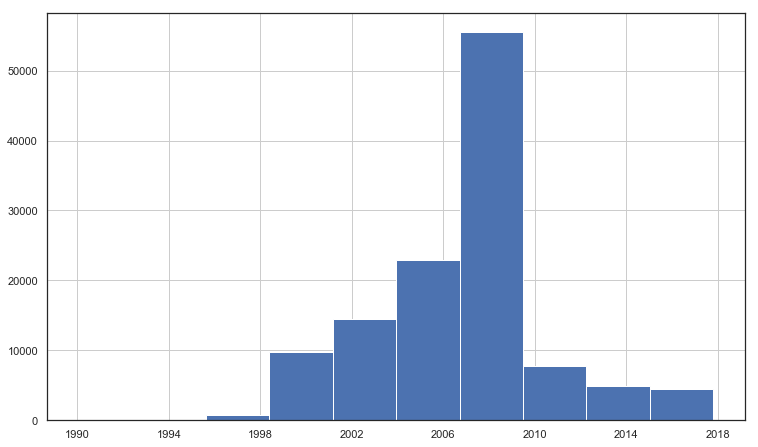

In [7]:
fig = plt.figure(figsize=(12.5, 7.5))

tenure_df['Earliest Date'].hist()

fig.axes[0].xaxis_date()

We have a peak in late-2000s on new participation, with a sudden drop-off. (Caution, that is likely just be where the peak of this corpus of messages is present, including one-off spam messages, especially since the histogram also peaks there for last message sent.)

We can calculate a "tenure" concept, which is the number of days between your first message to an IETF list and your latest message.

In [8]:
tenure_df['Tenure'] = tenure_df['Latest Date'] - tenure_df['Earliest Date']

In [9]:
tenure_df.describe()

,Earliest Date,Total Messages,Latest Date,Tenure
count,120482.000000,120482.000000,120482.000000,120482.000000
mean,732565.354717,11.125031,732703.914975,138.560258
std,1356.567602,121.356436,1439.607299,504.066730
min,726496.000000,1.000000,726496.000000,0.000000
25%,731855.000000,1.000000,731965.000000,0.000000
50%,732752.000000,1.000000,732793.000000,0.000000
75%,733037.000000,2.000000,733057.000000,1.000000
max,736622.000000,20279.000000,736625.000000,7408.000000


Let's graph data for people for whom we have at least a few messages.

In [10]:
working_data = tenure_df[tenure_df['Total Messages'] > 3]

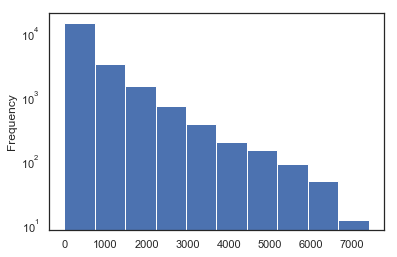

In [11]:
working_data['Tenure'].plot(kind ='hist',logy=True)

The distribution of tenure seems to be a power law, although not exactly. (The above graph is log scale in the y dimension.) Most people have short tenures, with fewer and fewer people as the tenure extends.

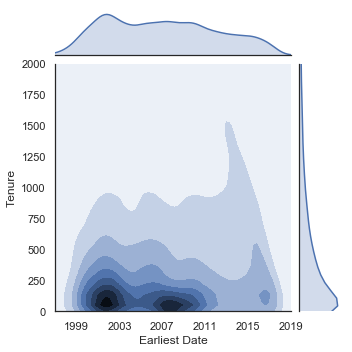

In [71]:
fig = sns.jointplot(kind='kde', 
                    data = working_data, 
                    x='Earliest Date', 
                    y='Tenure', 
                    xlim=(datetime.date(1997,1,1).toordinal(),datetime.date(2019,1,1).toordinal()), 
                    ylim=(0, 2000),
                    height=5)
fig.ax_joint.xaxis_date()
fig.savefig('graphs/tenure-density-plot.png',dpi=300)

This plot shows the density of people around when they first sent a message and how long their tenure has been. Maybe this can help us answer the question: are the earlier participants more likely to be long-lasting? This suggests that that isn't the case, that there is even a slight tendency for the long-tenure participants to be more recent joiners. (Caveat, that might also be an artifact of the corpus being WGs that are still active.)

For the subset of senders who have more than 3 total messages, let's see when they first and last sent messages. (Latest Date has a histogram peak in the most recent year because for everyone who's still sending messages, their last message can't be later than this year.)

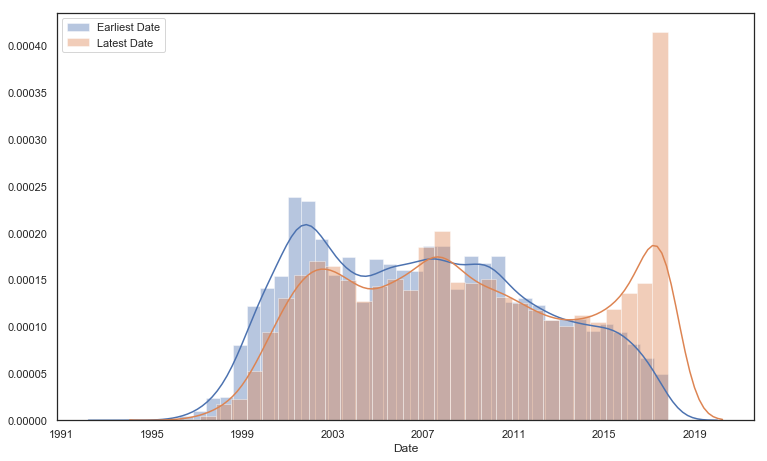

In [72]:
fig = plt.figure(figsize=(12.5, 7.5))

ax = sns.distplot(working_data['Earliest Date'],label='Earliest Date')
sns.distplot(working_data['Latest Date'],label='Latest Date', ax=ax, axlabel='Date')
ax.legend()
ax.xaxis_date()
fig.savefig('graphs/earliest-latest-histograms.png',dpi=300)

I'd like to show overlapping horizontal line segments in order to give an impression of the overlapping tenures of participation. Let's try?

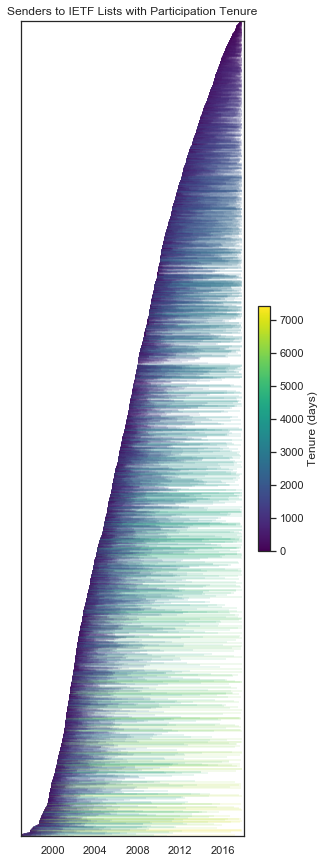

In [73]:
sorted_df = working_data.sort_values(by=['Earliest Date'])

ys= np.arange(sorted_df['From'].count())
segments = []
for y in ys:
    start = [sorted_df['Earliest Date'].iloc[y], y]
    end = [sorted_df['Latest Date'].iloc[y], y]
    segments.append([start,end])
line_segments = matplotlib.collections.LineCollection(segments, 
                                                      linewidths=[0.2], 
                                                      cmap='viridis', 
                                                      norm=matplotlib.colors.Normalize(vmin=0,vmax=7408))
line_segments.set_array(sorted_df['Tenure'])

fig = plt.figure(figsize=(5, 15))
ax = plt.axes()
ax.set_xlim(datetime.date(1997,1,1).toordinal(),datetime.date(2018,1,1).toordinal())
ax.set_ylim(ys.min(), ys.max())
ax.xaxis_date()
ax.yaxis.set_visible(False)
ax.add_collection(line_segments)
cb = fig.colorbar(line_segments, shrink=0.3)
cb.set_label('Tenure (days)')
ax.set_title('Senders to IETF Lists with Participation Tenure')
fig.savefig('graphs/tenure-lines.png',dpi=300)